# BUILDING OUR MODEL(XGBOOST)

In [1]:
import pyforest
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier



In [2]:
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

<IPython.core.display.Javascript object>

In [3]:
df['target'] = data.target
df.head()


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

In [4]:
y=df['target'].to_frame() # define Y
X=df[df.columns.difference(['target'])] # define X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test

<IPython.core.display.Javascript object>

In [5]:
# build model - Xgboost
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel()) 



<IPython.core.display.Javascript object>

c:\Users\25470\anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [10:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)


In [6]:
# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)


c:\Users\25470\anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [10:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [7]:
# Performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.61%


# SHAP

In [8]:
# Generate the Tree explainer and SHAP values
import shap 
explainer = shap.TreeExplainer(xgb_mod)
shap.initjs()
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

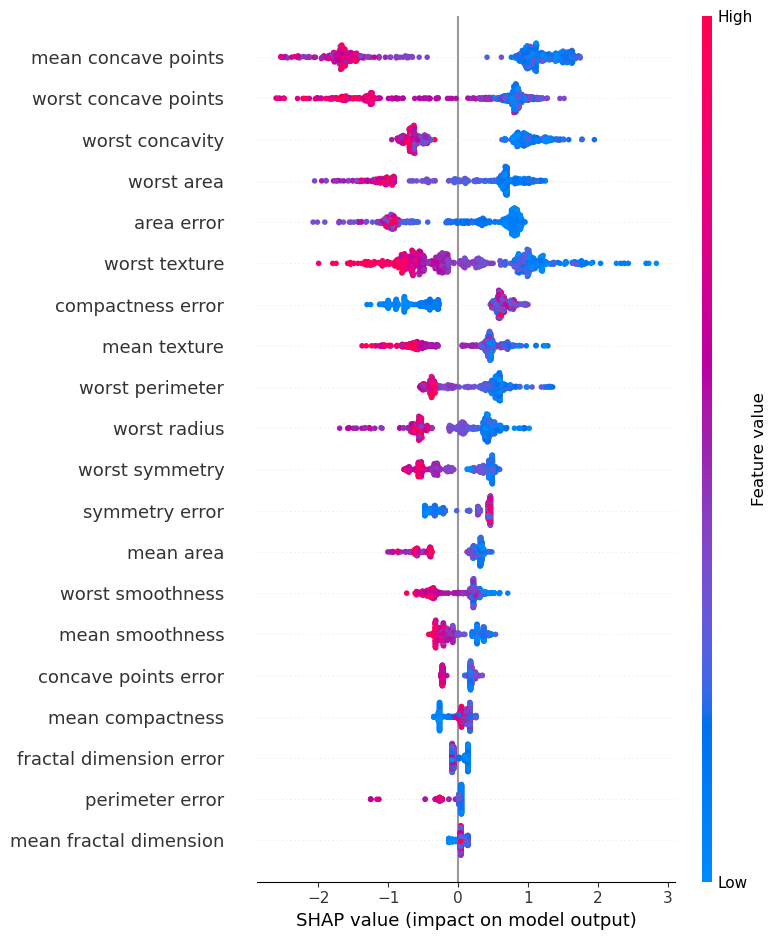

In [9]:
############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot") 

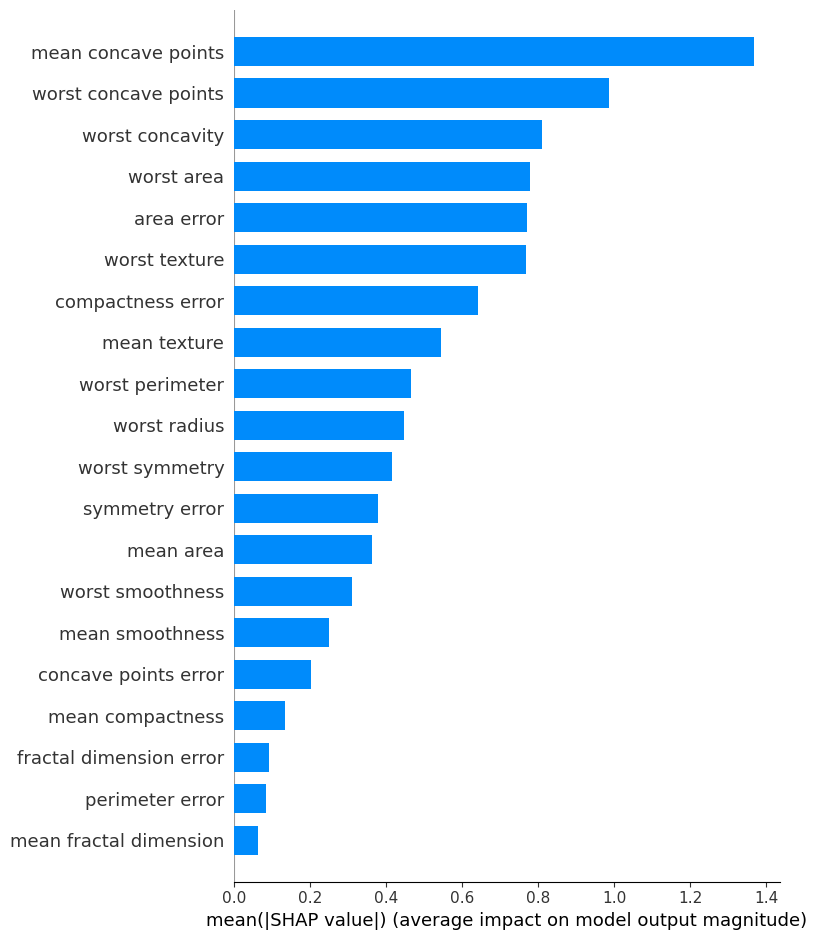

In [10]:
# Generate summary bar plot 
shap.summary_plot(shap_values, X,plot_type="bar") 


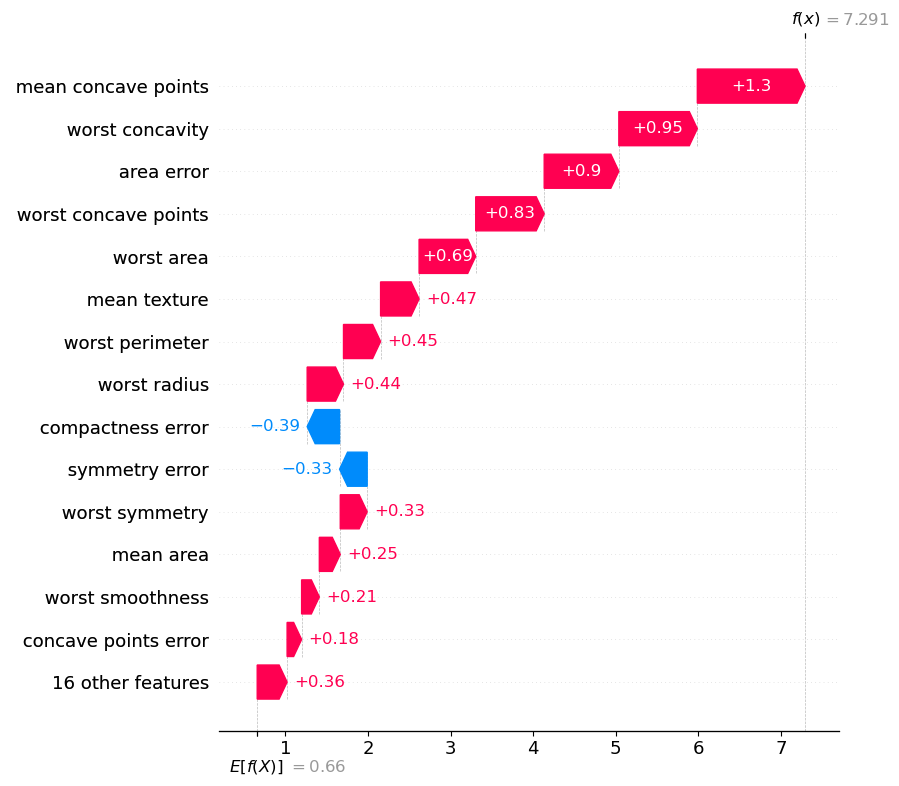

In [11]:
# Generate waterfall plot  
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[79], features=X.loc[79,:], feature_names=X.columns, max_display=15, show=True)

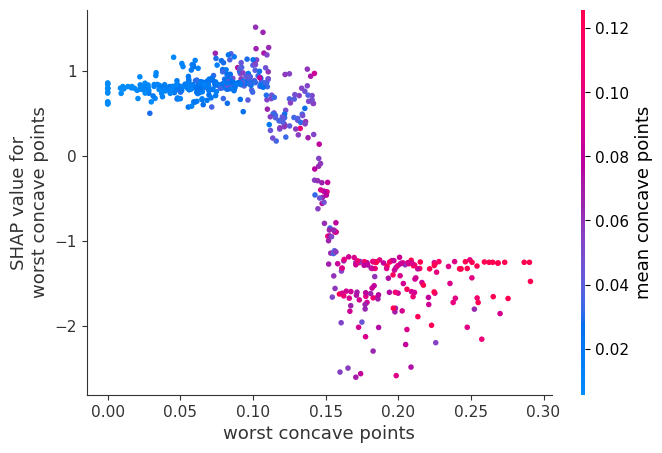

In [12]:
# Generate dependence plot
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

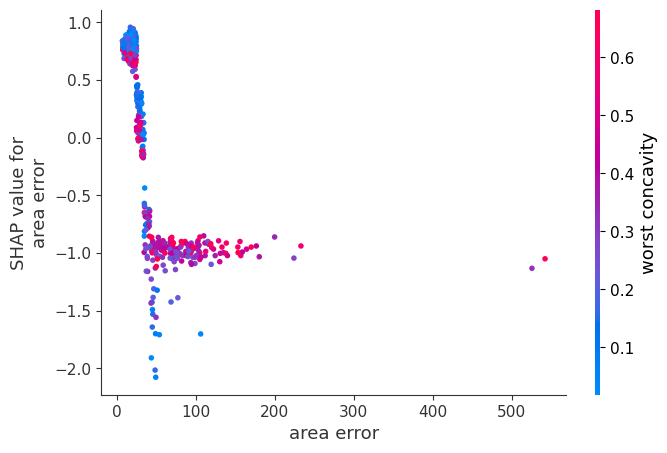

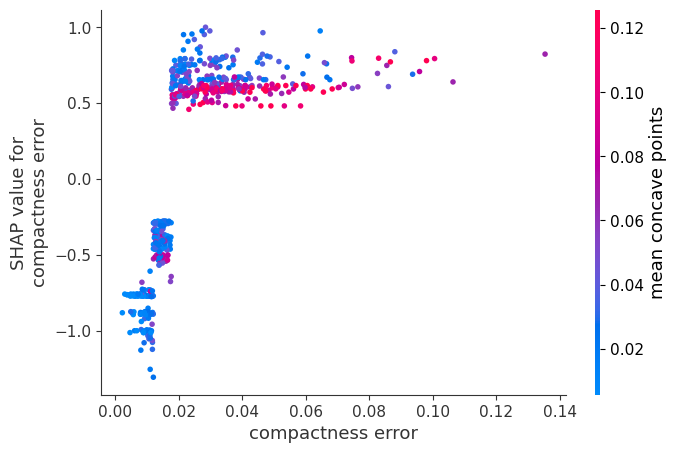

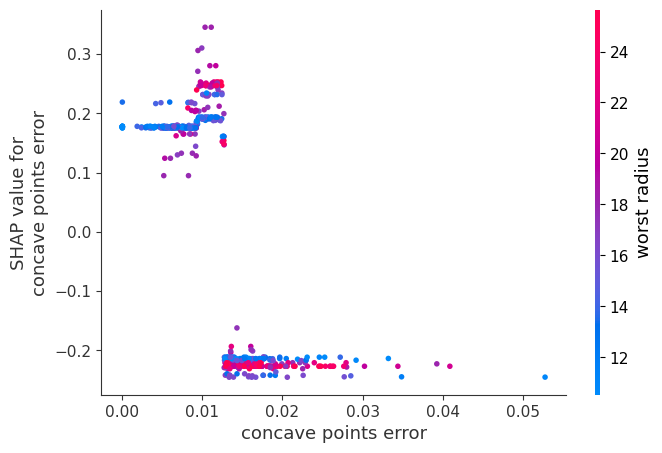

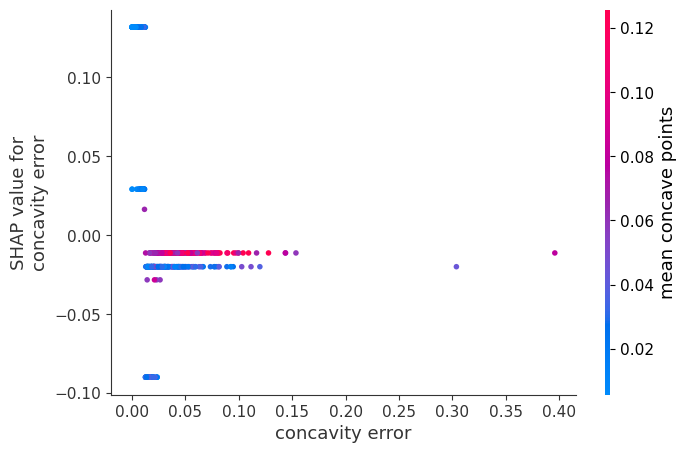

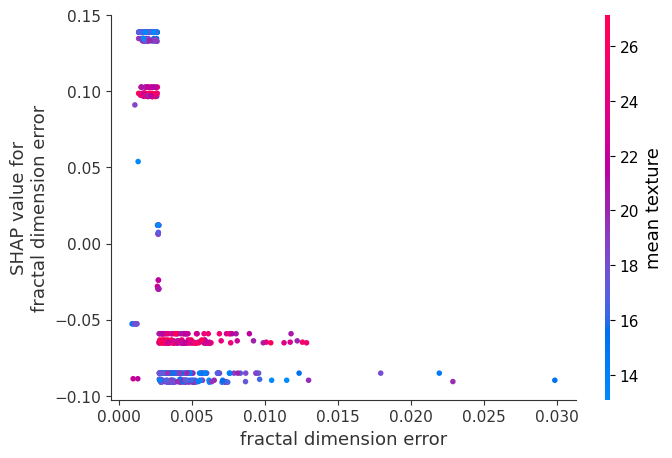

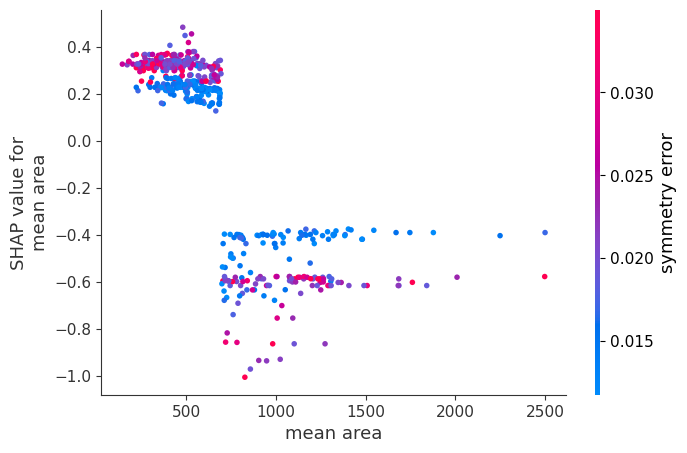

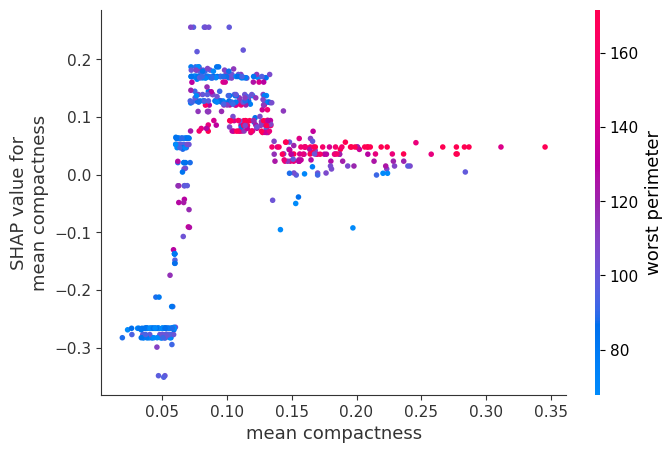

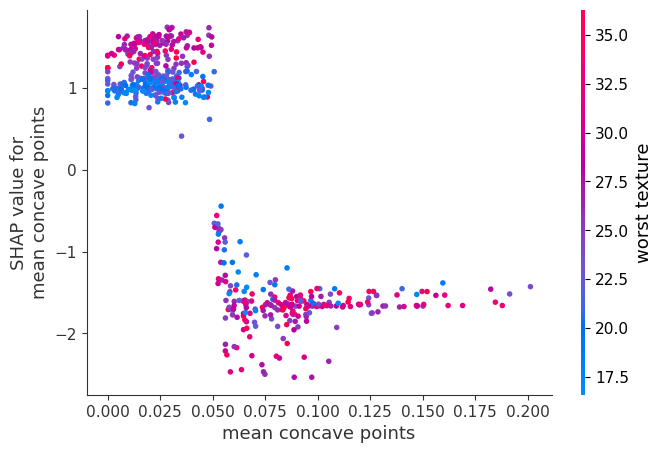

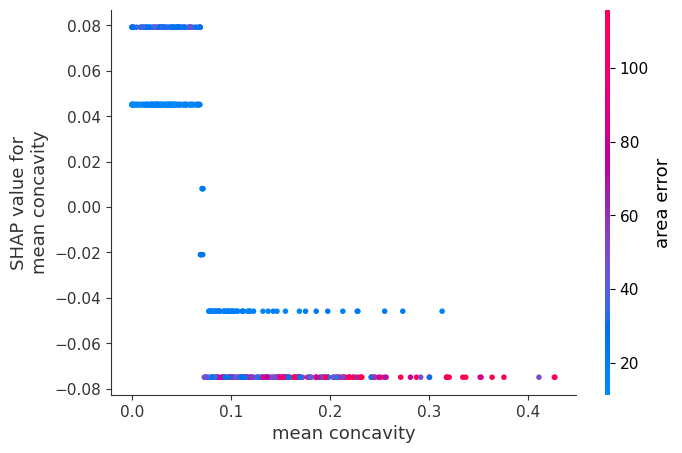

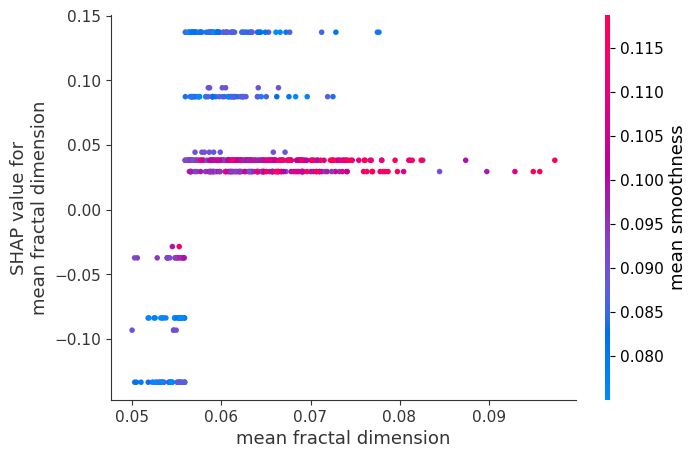

c:\Users\25470\anaconda\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\25470\anaconda\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


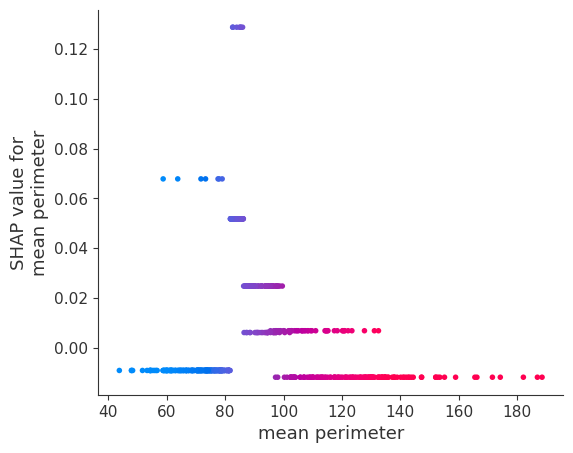

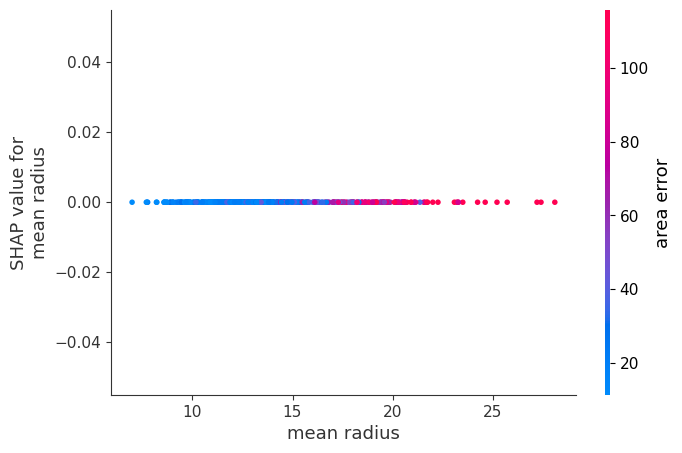

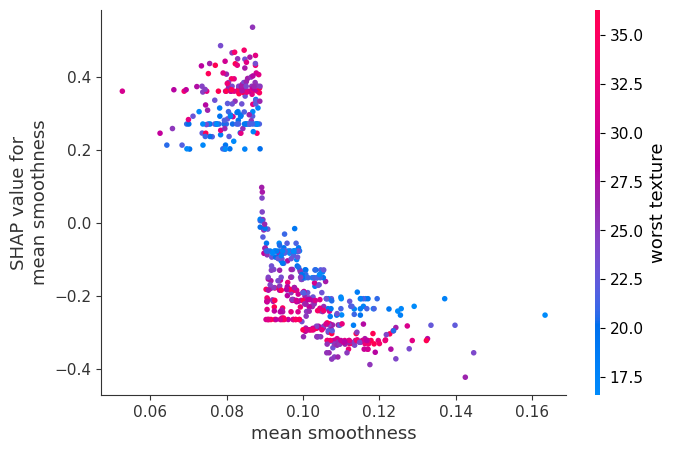

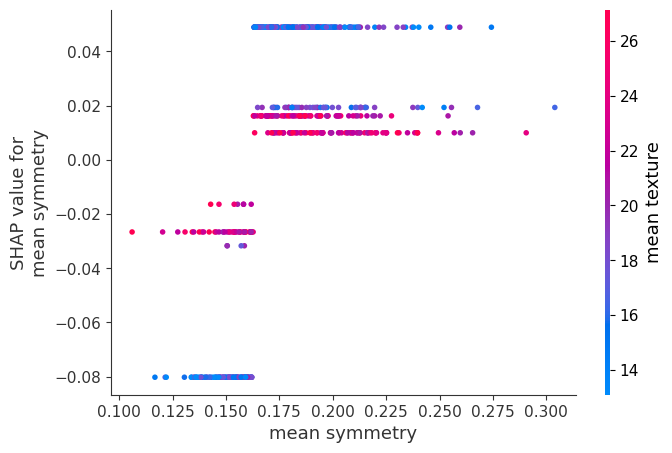

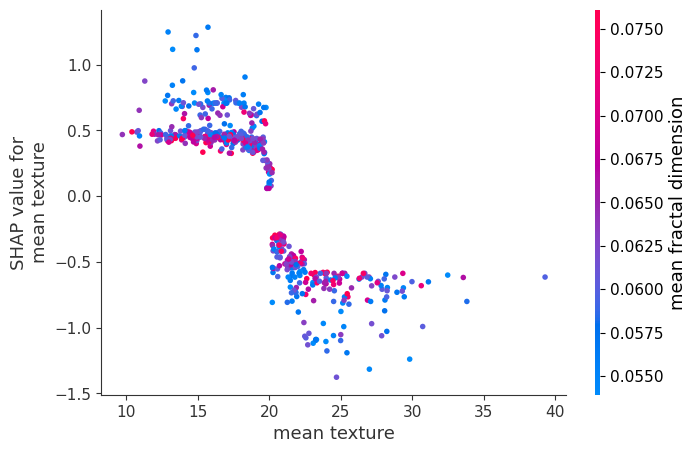

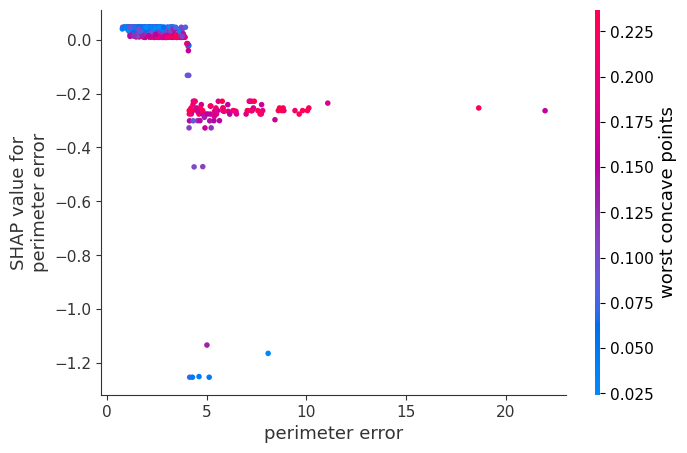

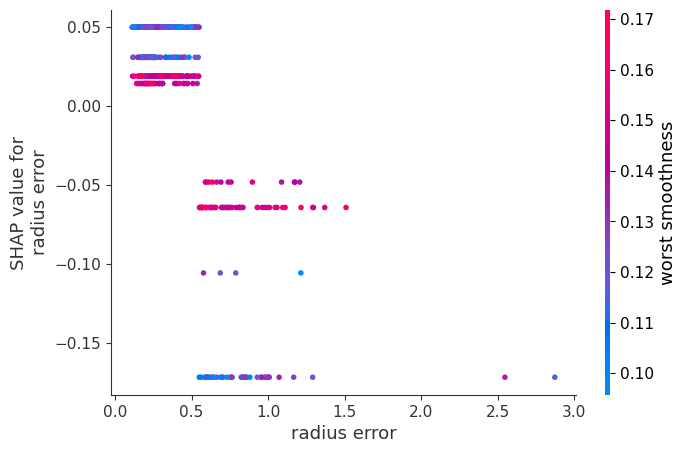

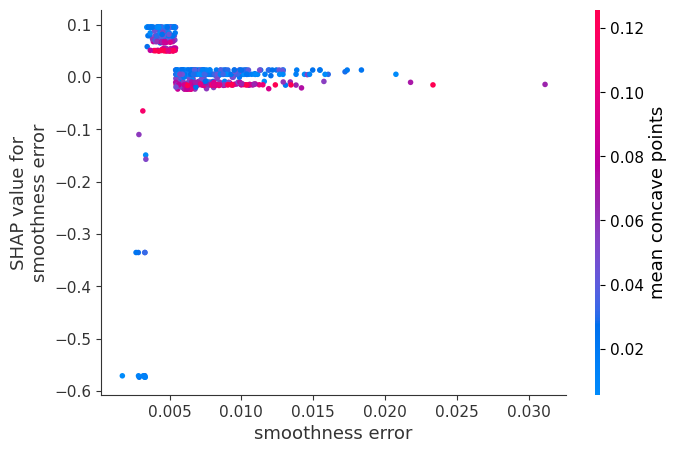

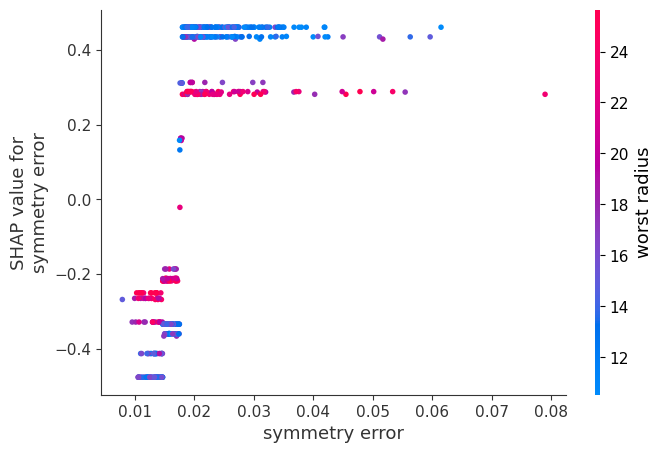

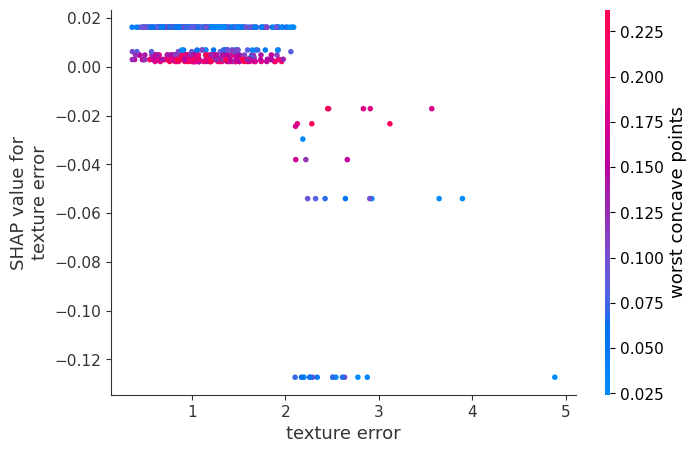

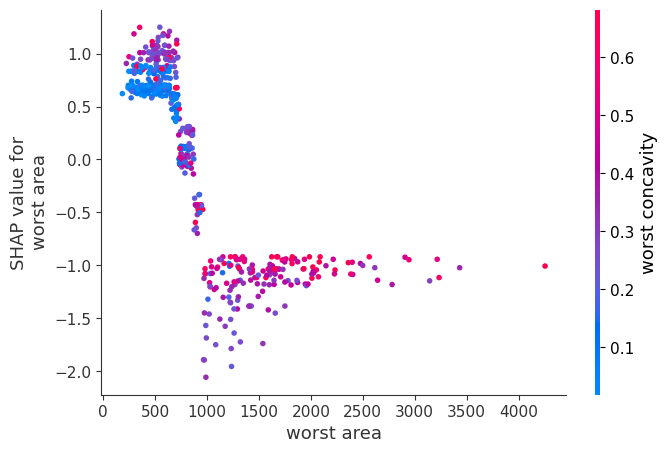

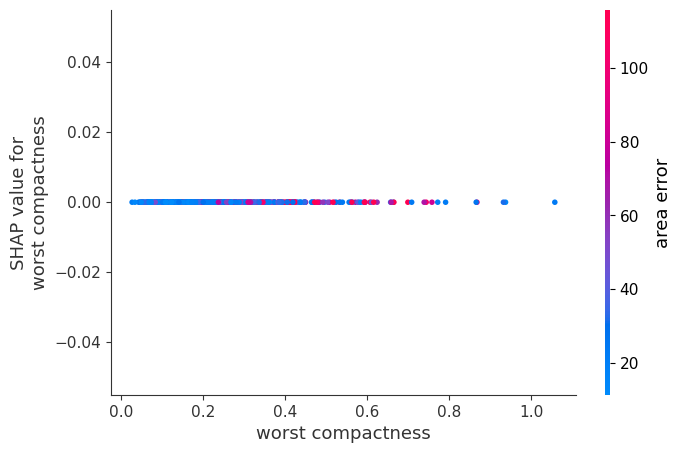

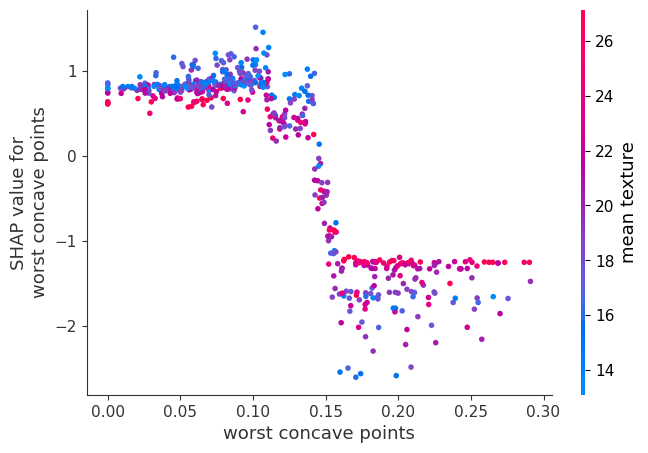

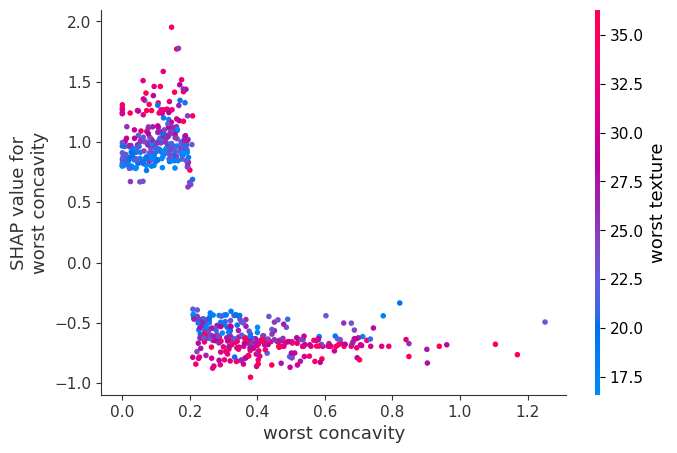

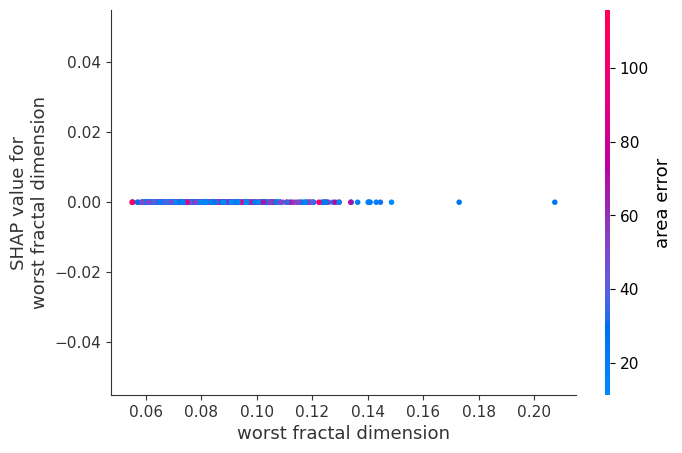

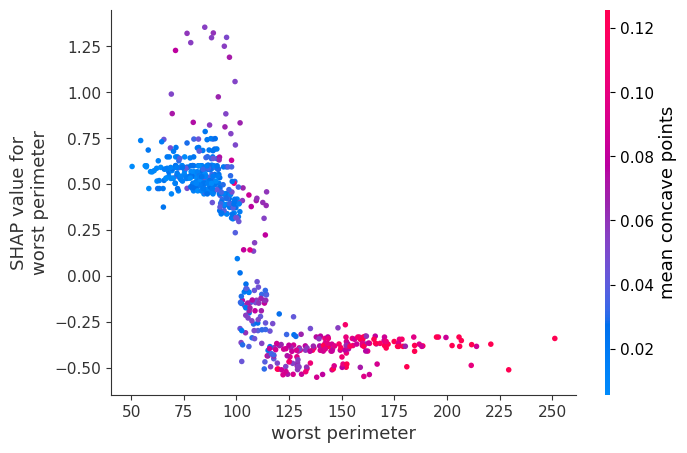

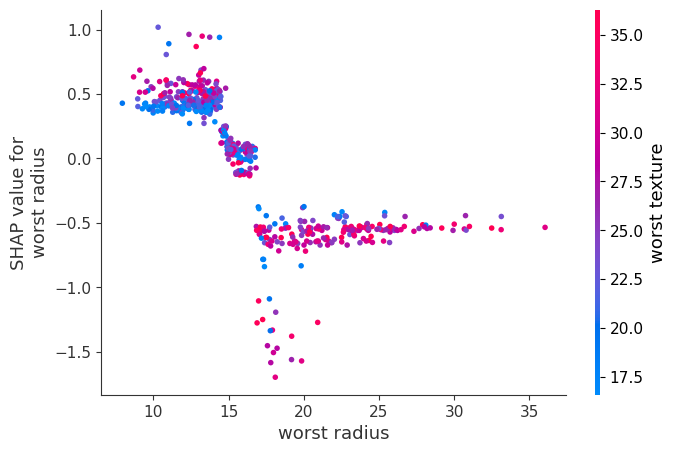

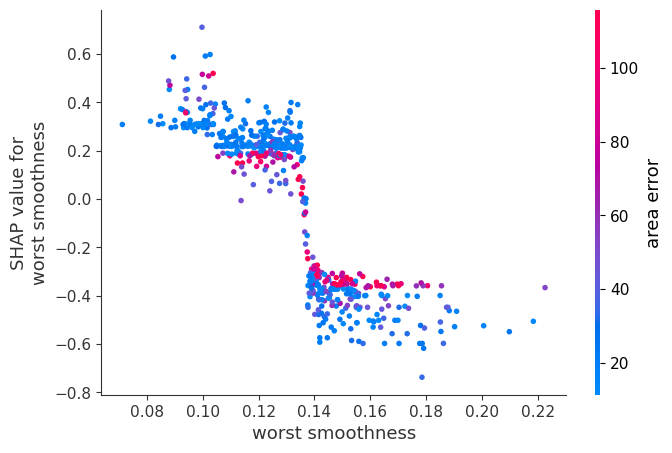

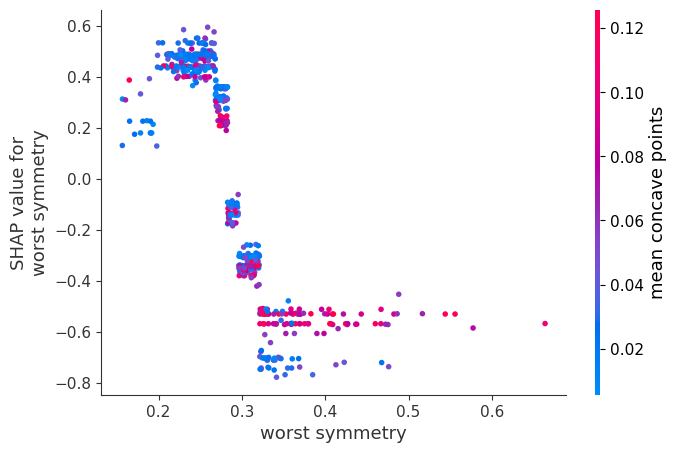

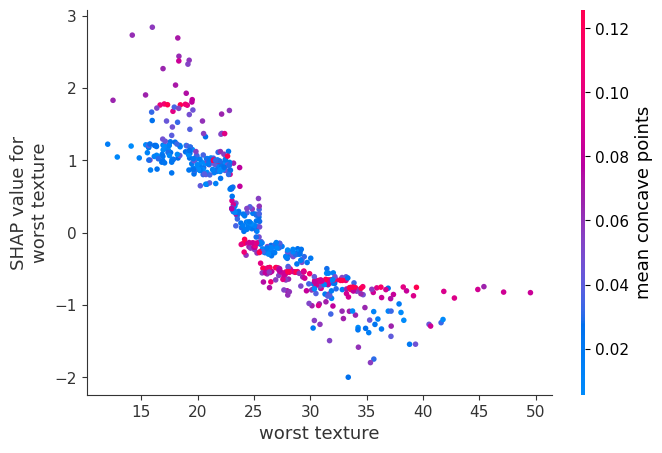

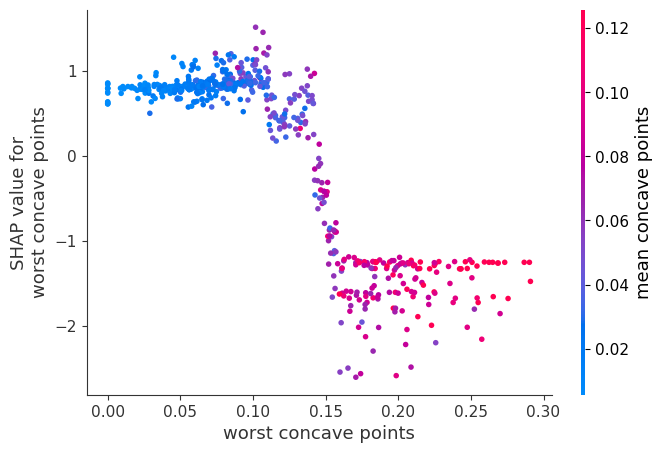

In [13]:
# Generate multiple dependence plots
for name in X_train.columns:
     shap.dependence_plot(name, shap_values, X)
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")


In [14]:

shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

In [15]:
# Generate force plot - Single
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [16]:
# Generate force plot - Single
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# LIME

In [17]:
# Utilizing our same xgb_mod model object created above
# Import pacakages
import lime
import lime.lime_tabular
import numpy as np



In [18]:
############## create explainer ###########
# we use the dataframes splits created above for SHAP
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.to_numpy(), feature_names=X_test.columns, class_names=['0','1'], verbose=True)

In [19]:
############## visualizations #############
row = X_test.iloc[79]
exp = explainer.explain_instance(row.to_numpy(), xgb_mod.predict_proba, num_features=20)

exp.show_in_notebook(show_table=True)

Intercept 0.4812142677660639
Prediction_local [1.04943047]
Right: 0.9943189


In [20]:
print(X_test.index)

Index([204,  70, 131, 431, 540, 567, 369,  29,  81, 477,
       ...
       549, 530, 163, 503, 148, 486,  75, 249, 238, 265],
      dtype='int64', length=114)


# SHAPASH

In [21]:
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
import shapash
import shap
import datatable as dt # data table factory
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from shapash.utils.load_smartpredictor import load_smartpredictor
from shapash.explainer.smart_explainer import SmartExplainer

ImportError: cannot import name 'escape' from 'jinja2' (c:\Users\25470\anaconda\lib\site-packages\jinja2\__init__.py)

In [ ]:
############# launch the app #############
# create explainer
from shapash.explainer.smart_explainer import SmartExplainer

xpl = SmartExplainer(model=xgb_mod)


: 

In [ ]:
xpl.compile(
    x=X_test,
)

: 

In [ ]:
app = xpl.run_app(title_story='Breast Cancer')


: 

In [ ]:
import explainerdashboard as expdb
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from explainerdashboard import InlineExplainer
from explainerdashboard.custom import (ImportancesComposite,
                                       IndividualPredictionsComposite,
                                       WhatIfComposite,
                                       ShapDependenceComposite,
                                       ShapInteractionsComposite,
                                       DecisionTreesComposite)

: 

In [ ]:
# Create the explainer object
explainer = ClassifierExplainer(xgb_mod, X_test, y_test,model_output='logodds')

: 

In [ ]:
dashboard = ExplainerDashboard(explainer)


: 

# INTERPRET ML 

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
ebm = ExplainableBoostingRegressor()
ebm.fit(X_test,y_train)

: 

# PERMUTATION IMPORTANCE 

In [23]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(xgb_mod, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get sorted importances
sorted_idx = result.importances_mean.argsort()

# Visualize
for index in sorted_idx:
    print(f"{X_test.columns[index]}: {result.importances_mean[index]:.4f}")


worst concavity: -0.0105
worst symmetry: -0.0105
worst concave points: -0.0105
worst radius: -0.0088
worst smoothness: -0.0088
symmetry error: -0.0070
mean area: -0.0061
mean smoothness: -0.0053
concave points error: -0.0053
worst area: -0.0026
perimeter error: -0.0026
worst perimeter: -0.0009
worst fractal dimension: 0.0000
mean symmetry: 0.0000
mean perimeter: 0.0000
mean fractal dimension: 0.0000
radius error: 0.0000
smoothness error: 0.0000
mean concavity: 0.0000
texture error: 0.0000
mean compactness: 0.0000
worst compactness: 0.0000
fractal dimension error: 0.0000
concavity error: 0.0000
mean radius: 0.0000
mean texture: 0.0009
area error: 0.0018
mean concave points: 0.0026
compactness error: 0.0053
worst texture: 0.0096


## INSIGHTS 
1. **NEGATIVE VALUES**such a worst concavity , worst symmetry suggestd that permutation of this features slightly improves model performance. This could indicate overfitting i.e overfit to noise or non generalized patterns during training data 
2. **ZERO VALUES** such as worst fractional dimension and mean symmetry indicate permuting such features do not have an effect on the model performance .This means the model do not rely on such features for making information i.e irrelevance information or redudant information 
3. **POSITIVE VALUES** genuinely contribute to the predictive power of the model.This means a decrease in model performance when shuffled showing this model relies on these features for prediction 

# How to use the information 
1. Model simplification -You might consider removing features with zero and negative importance to simplify the model 
2. Focus on important features -Features with positive importance scores are critical and could be subjected to further analysis ,feature engineering and domain investigation 
3. Reevaluate the Data and model 
